In [1]:
# In this notebook we create a model (RandomForestClassifier) that classifies each tweet (written in Greek) as neutral, positive or negative

In [2]:
import pandas as pd
from collections import Counter

#!pip install lime
#from lime.lime_text import LimeTextExplainer

# print non truncated column info in pandas dataframe
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', 500)

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
#from sklearn.tree import DecisionTreeClassifier
#from sklearn.svm import SVC
#!pip install xgboost --user
#from xgboost import XGBClassifier


import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support

In [4]:
# read the dataset with the rated tweets, features and sentiment
df_train = pd.read_pickle('data/df_final.pkl')

In [5]:
df_train.head(1)

,Text,Text_only,Tokens,Tokens_stem,Bigrams2,N_exclam,has_url,N_hash,N_mentions,N_uppers,N_words,Sentiment,N_matches,Match_Terms,Sum_subj,Sum_positive,Sum_negative,Sum_anger,Sum_disgust,Sum_fear,Sum_happy,Sum_sad,Sum_surprise,N_Uni_Neg,Score_Uni_Neg,N_Uni_Pos,Score_Uni_Pos,N_Bi_Neg,Score_Bi_Neg,N_Bi_Pos,Score_Bi_Pos,Score_Uni,Score_Bi,N_verbs,N_adjs,N_nouns
0,Επιχείρηση Βολευτική έδρα! Βασίλης Οικονόμου: Από το ΠΑΣΟΚ διαγράφηκε απο το ΓΑΠ επειδη ΔΕΝ ψήφισε το Μνημόνιο... http://t.co/gPgr1Caqxv,Επιχείρηση Βολευτική έδρα! Βασίλης Οικονόμου: Από το ΠΑΣΟΚ διαγράφηκε απο το ΓΑΠ επειδη ΔΕΝ ψήφισε το Μνημόνιο...,"[ΕΠΙΧΕΙΡΗΣΗ, ΒΟΛΕΥΤΙΚΗ, ΕΔΡΑ, ΒΑΣΙΛΗΣ, ΟΙΚΟΝΟΜΟΥ, ΑΠΟ, ΤΟ, ΠΑΣΟΚ, ΔΙΑΓΡΑΦΗΚΕ, ΑΠΟ, ΤΟ, ΓΑΠ, ΕΠΕΙΔΗ, ΔΕΝ, ΨΗΦΙΣΕ, ΤΟ, ΜΝΗΜΟΝΙΟ]","[ΕΠΙΧΕΙΡΗΣ, ΒΟΛΕΥΤ, ΕΔΡ, ΒΑΣΙΛ, ΟΙΚΟΝΟΜ, ΑΠΟ, ΤΟ, ΠΑΣΟΚ, ΔΙΑΓΡΑΦ, ΑΠΟ, ΤΟ, ΓΑΠ, ΕΠΕΙΔΗ, ΔΕΝ, ΨΗΦΙΣ, ΤΟ, ΜΝΗΜΟΝ]","[ΕΠΙΧΕΙΡΗΣΗ ΒΟΛΕΥΤΙΚΗ, ΒΟΛΕΥΤΙΚΗ ΕΔΡΑ, ΕΔΡΑ ΒΑΣΙΛΗΣ, ΒΑΣΙΛΗΣ ΟΙΚΟΝΟΜΟΥ, ΟΙΚΟΝΟΜΟΥ ΑΠΟ, ΑΠΟ ΤΟ, ΤΟ ΠΑΣΟΚ, ΠΑΣΟΚ ΔΙΑΓΡΑΦΗΚΕ, ΔΙΑΓΡΑΦΗΚΕ ΑΠΟ, ΑΠΟ ΤΟ, ΤΟ ΓΑΠ, ΓΑΠ ΕΠΕΙΔΗ, ΕΠΕΙΔΗ ΔΕΝ, ΔΕΝ ΨΗΦΙΣΕ, ΨΗΦΙΣΕ ΤΟ, ΤΟ ΜΝΗΜΟΝΙΟ]",1,1,0,0,3,17,-1,1,[ΤΟ],0.375,0.0,0.75,0.0,0.0,0.0,0.0,0.0,0.0,13,-7.609859,3,1.924791,7,-8.893361,2,1.640151,-5.685068,-7.253209,2,1,6


In [6]:
df_train.shape

(1640, 36)

In [7]:
# check the percentage of tweets for each sentiment
df_train['Sentiment'].value_counts(normalize=True) * 100

 0    59.695122
-1    35.487805
 1    4.817073 
Name: Sentiment, dtype: float64

In [8]:
df_train.columns

Index(['Text', 'Text_only', 'Tokens', 'Tokens_stem', 'Bigrams2', 'N_exclam',
       'has_url', 'N_hash', 'N_mentions', 'N_uppers', 'N_words', 'Sentiment',
       'N_matches', 'Match_Terms', 'Sum_subj', 'Sum_positive', 'Sum_negative',
       'Sum_anger', 'Sum_disgust', 'Sum_fear', 'Sum_happy', 'Sum_sad',
       'Sum_surprise', 'N_Uni_Neg', 'Score_Uni_Neg', 'N_Uni_Pos',
       'Score_Uni_Pos', 'N_Bi_Neg', 'Score_Bi_Neg', 'N_Bi_Pos', 'Score_Bi_Pos',
       'Score_Uni', 'Score_Bi', 'N_verbs', 'N_adjs', 'N_nouns'],
      dtype='object')

In [9]:
# create a list with the features that are used in the modeling 
features = ['N_exclam',
       'has_url', 'N_hash', 'N_mentions', 'N_uppers', 'N_words', 'Sum_subj', 'Sum_positive', 'Sum_negative',
       'Sum_anger', 'Sum_disgust', 'Sum_fear', 'Sum_happy', 'Sum_sad',
       'Sum_surprise', 'N_Uni_Neg', 'Score_Uni_Neg', 'N_Uni_Pos',
       'Score_Uni_Pos', 'N_Bi_Neg', 'Score_Bi_Neg', 'N_Bi_Pos', 'Score_Bi_Pos',
       'Score_Uni', 'Score_Bi', 'N_verbs', 'N_adjs', 'N_nouns']

### Modeling

In [10]:
X = df_train[features]
Y = df_train['Sentiment']
Z = df_train['Text']

In [11]:
X.head(2)

,N_exclam,has_url,N_hash,N_mentions,N_uppers,N_words,Sum_subj,Sum_positive,Sum_negative,Sum_anger,Sum_disgust,Sum_fear,Sum_happy,Sum_sad,Sum_surprise,N_Uni_Neg,Score_Uni_Neg,N_Uni_Pos,Score_Uni_Pos,N_Bi_Neg,Score_Bi_Neg,N_Bi_Pos,Score_Bi_Pos,Score_Uni,Score_Bi,N_verbs,N_adjs,N_nouns
0,1,1,0,0,3,17,0.375,0.00,0.75,0.0,0.0,0.0,0.0,0.0,0.0,13,-7.609859,3,1.924791,7,-8.893361,2,1.640151,-5.685068,-7.253209,2,1,6
1,0,1,0,0,2,14,0.250,0.25,0.25,0.0,0.0,0.0,0.0,0.0,0.0,7,-3.418189,4,1.804600,2,-1.838225,0,0.000000,-1.613589,-1.838225,1,0,6


### -- Split dataset to testset and trainset

In [12]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state = 0)

In [13]:
x_train.head(1)

,N_exclam,has_url,N_hash,N_mentions,N_uppers,N_words,Sum_subj,Sum_positive,Sum_negative,Sum_anger,Sum_disgust,Sum_fear,Sum_happy,Sum_sad,Sum_surprise,N_Uni_Neg,Score_Uni_Neg,N_Uni_Pos,Score_Uni_Pos,N_Bi_Neg,Score_Bi_Neg,N_Bi_Pos,Score_Bi_Pos,Score_Uni,Score_Bi,N_verbs,N_adjs,N_nouns
442,1,0,0,1,1,14,0.125,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,10,-5.685006,6,4.542664,6,-5.434132,1,0.898627,-1.142342,-4.535505,3,1,1


In [14]:
x_test.head(1)

,N_exclam,has_url,N_hash,N_mentions,N_uppers,N_words,Sum_subj,Sum_positive,Sum_negative,Sum_anger,Sum_disgust,Sum_fear,Sum_happy,Sum_sad,Sum_surprise,N_Uni_Neg,Score_Uni_Neg,N_Uni_Pos,Score_Uni_Pos,N_Bi_Neg,Score_Bi_Neg,N_Bi_Pos,Score_Bi_Pos,Score_Uni,Score_Bi,N_verbs,N_adjs,N_nouns
1570,0,1,0,0,0,7,0.125,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,6,-3.946406,1,0.04348,2,-1.413642,0,0.0,-3.902926,-1.413642,1,1,2


In [15]:
print("- Train sample size",x_train.shape,type(x_train))
print("- Test sample size",x_test.shape,type(x_test))

- Train sample size (1312, 28) <class 'pandas.core.frame.DataFrame'>
- Test sample size (328, 28) <class 'pandas.core.frame.DataFrame'>


### -- Hyperparameter tuning with GridSearchCV

In [16]:
rfc=RandomForestClassifier(random_state=42)

param_grid = { 
    'n_estimators': [200, 220],
    'max_features': ['sqrt'],
    'max_depth' : [7,8,9],
    'criterion' :['entropy']
}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(x_train, y_train)
print(CV_rfc.best_params_)

{'criterion': 'entropy', 'max_depth': 9, 'max_features': 'sqrt', 'n_estimators': 200}


In [17]:
model_RF = CV_rfc.best_estimator_
model_RF

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=9, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [18]:
clf = RandomForestClassifier(max_features='sqrt',
                             criterion='entropy',
                             n_estimators= 500,
                             max_depth=20).fit(x_train,y_train)

### -- Train the model

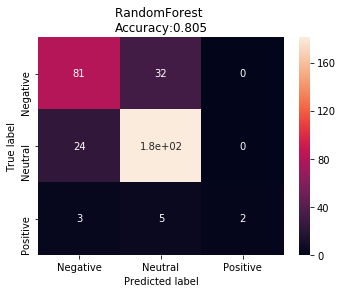

In [19]:
y_pred = clf.predict(x_test)

# Creates a confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = ['Negative','Neutral', 'Positive'], 
                     columns = ['Negative','Neutral', 'Positive'])

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True)
plt.title('RandomForest \nAccuracy:{0:.3f}'.format(accuracy_score(y_test, y_pred)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [24]:
metrics = precision_recall_fscore_support(y_test, y_pred)

precision = metrics[0]
recall = metrics[1]
f1 = metrics[2]
accuracy = metrics[3]

print('accuracy = ', accuracy_score(y_test, y_pred))
print(' ------ ')
print('precision_Neg = ', precision[0])
print('precision_Neut = ', precision[1])
print('precision_Pos = ', precision[2])
print(' ------ ')
print('recall_Neg = ', precision[0])
print('recall_Neut = ', precision[1])
print('recall_Pos = ', precision[2])
print(' ------ ')
print('f1_Neg = ', f1[0])
print('f1_Neut = ', f1[1])
print('f1_Pos = ', f1[2])

accuracy =  0.8048780487804879
 ------ 
precision_Neg =  0.75
precision_Neut =  0.8302752293577982
precision_Pos =  1.0
 ------ 
recall_Neg =  0.75
recall_Neut =  0.8302752293577982
recall_Pos =  1.0
 ------ 
f1_Neg =  0.7330316742081447
f1_Neut =  0.8557919621749409
f1_Pos =  0.33333333333333337


In [25]:
import pickle

# save the model to disk
filename = 'model/clf.sav'
pickle.dump(clf, open(filename, 'wb'))

# load the saved the model
filename = 'model/clf.sav'
loaded_model = pickle.load(open(filename, 'rb'))

C:\Users\Dimos\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.19.1 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\Dimos\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.19.1 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


### - Propabilities

In [26]:
# predict the propability for each class
predictions = clf.predict_proba(x_test)

In [27]:
# merge the y values of the testset with their tweet texts
df_texts = pd.DataFrame({'ID':Z.index, 'Text':Z.values})
df_actuals = pd.DataFrame({'ID':y_test.index, 'Actual':y_test.values})
df_ytest = df_actuals.merge(df_texts, left_on='ID', right_on='ID', how='left')
del df_ytest['ID']

In [28]:
# create a dataframe with the tweets of the testset and the probabilities + predictions + actuals
headers = ['Neg', 'Neut', 'Pos']
df = pd.DataFrame(predictions, columns=headers)

df['Prediction'] = y_pred
df['Actual_Text'] = df_ytest.values.tolist()
df['Actual'] = df['Actual_Text'].apply(lambda x: x[0])
df['Text'] = df['Actual_Text'].apply(lambda x: x[1])
df['True'] = df.apply(lambda x: 1 if x['Prediction']==x['Actual']
                                   else 0, axis=1)
del df['Actual_Text']
df = df[['Text', 'Neg', 'Neut', 'Pos', 'Prediction', 'Actual', 'True']]

In [29]:
df.head(2)

,Text,Neg,Neut,Pos,Prediction,Actual,True
0,Στόχο τον Λαζόπουλο έβαλε η Νέα Δημοκρατία http://t.co/g648fGioQn,0.158,0.8067,0.0353,0,0,1
1,Σαμαράς: Ο ΣΥΡΙΖΑ θα οδηγήσει την χώρα στην χρεοκοπία http://t.co/1TPh8OHIlp #Πολιτική @madata,0.156,0.8100,0.0340,0,-1,0


In [30]:
#class_names = ['-1', '0', '1']
#explainer = LimeTextExplainer(class_names=class_names)

In [31]:
# idx = 1
# exp = explainer.explain_instance(x_test[idx], clf.predict_proba, num_features=6, labels=[0, 3])
# print('Document id: %d' % idx)
# print('Predicted class =', class_names[clf.predict(x_test[idx]).reshape(1,-1)[0,0]])
# print('True class: %s' % class_names[y_test[idx]])